### Visualizations

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

### - Visualization of p-values vs median scores for each MOAs per dose

In [2]:
cp_level4_path = 'cellpainting_lvl4_cpd_replicate_datasets'

In [3]:
df_cpd_median_scores = pd.read_csv(os.path.join(cp_level4_path, 'cpd_replicate_median_scores.csv'))
df_null_p_vals = pd.read_csv(os.path.join(cp_level4_path, 'cpd_replicate_p_values.csv'))

In [4]:
df_level4 = pd.read_csv(os.path.join(cp_level4_path, 'cp_level4_cpd_replicates.csv.gz'), 
                        compression='gzip',low_memory = False)

with open(os.path.join(cp_level4_path, 'null_distribution.pickle'), 'rb') as handle:
    null_distribution_replicates = pickle.load(handle)

In [5]:
def rename_cols(df):
    'Rename columns from dose number to actual doses'
    
    df.rename(columns= {'dose_1' : '0.04 uM', 'dose_2':'0.12 uM', 'dose_3':'0.37 uM',
                        'dose_4': '1.11 uM', 'dose_5':'3.33 uM', 'dose_6':'10 uM'}, inplace = True)
    return df

In [6]:
df_cpd_median_scores = rename_cols(df_cpd_median_scores)
df_null_p_vals = rename_cols(df_null_p_vals)

In [7]:
def melt_df(df, col_name):
    """
    This function returns a reformatted dataframe with 
    3 columns: cpd, dose number and dose_values(median score or p-value)
    """
    df = df.melt(id_vars=['cpd', 'cpd_size'], var_name="dose", value_name=col_name)
    return df

In [8]:
def merge_p_median_vals(df_cpd_vals, df_null):
    """
    This function merge p_values and median scores 
    dataframes for each compound for all doses(1-6) 
    """
    df_p_vals = melt_df(df_null, 'p_values')
    df_cpd_vals = melt_df(df_cpd_vals, 'median_scores')
    df_cpd_vals['p_values'] = df_p_vals['p_values']
    return df_cpd_vals

In [9]:
def plot_p_vs_median(df, path, file_name):
    
    """plot p_values vs median correlation scores for each compound for all doses (1-6)"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,8)) 
    plt.xlabel("Median scores of pairwise correlation btw cpds")
    plt.ylabel("Non-parametric P-values")
    plt.title("P-values vs median scores for compound replicates")
    fig = sns.scatterplot(data=df, x="median_scores", y="p_values", hue="dose", style="dose")
    fig.axhline(0.05, ls='--', c='black')
    fig.legend(loc = 'upper right')
    fig.text(-0.45,0.07, "Significance level (0.05)")
    plt.savefig(os.path.join(path, file_name))
    plt.show()

In [10]:
df_medians_p_vals = merge_p_median_vals(df_cpd_median_scores, df_null_p_vals)

|dose value(uM)| Dose |
|  :--------:  | :--: |
| ~0.04 | 1 |
| ~0.12 | 2 |
| ~0.37 | 3 |
| ~1.11 | 4 |
| ~3.33 | 5 |
| ~10 | 6 |

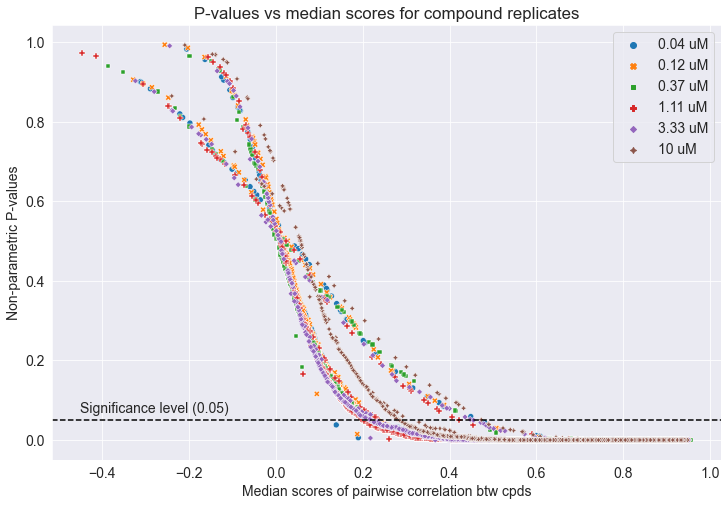

In [11]:
plot_p_vs_median(df_medians_p_vals, 'cellpainting_figures', 'p_vs_median.png')

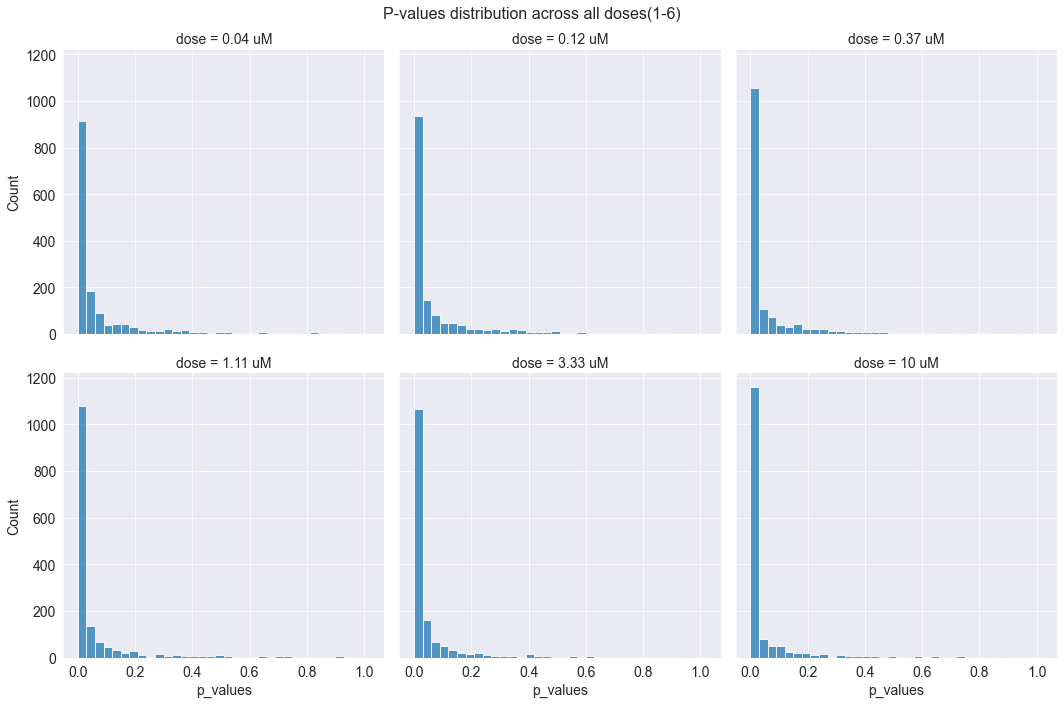

In [12]:
def plot_p_value_dist(df, path, file_name):
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    dis_plt = sns.displot(df, x="p_values", col="dose", col_wrap=3, binwidth=0.03)
    dis_plt.fig.suptitle("P-values distribution across all doses(1-6)", size = 16)
    dis_plt.fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    
    
plot_p_value_dist(df_medians_p_vals, 'cellpainting_figures', 'p_value_distribution.png')

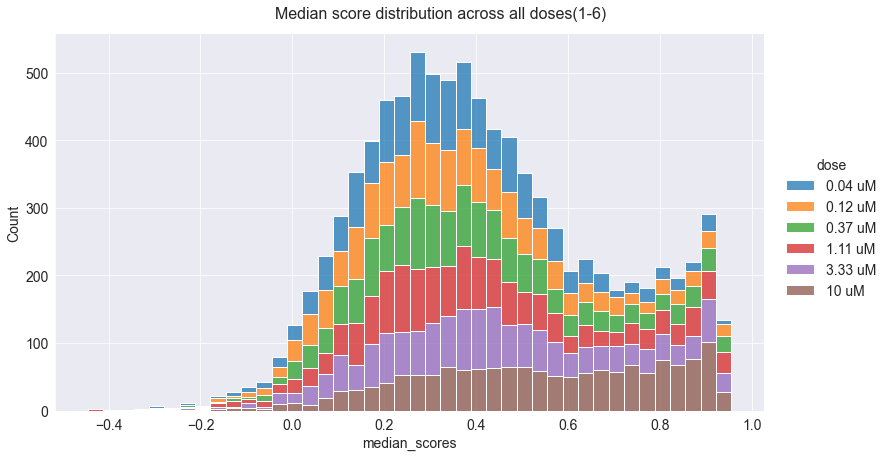

In [13]:
def plot_median_score_distribution(df, title, path, file_name):
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    dis_plt = sns.displot(df, x="median_scores", hue="dose", kind="hist", 
                          multiple="stack", height=6.5, aspect=1.7)
    dis_plt.fig.suptitle(title, size = 16)
    dis_plt.fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    
plot_median_score_distribution(df_medians_p_vals, "Median score distribution across all doses(1-6)",
                               'cellpainting_figures', 'median_score_distribution.png')

### - Replicate versus Non-replicate distribution across all doses (1-6)

In [14]:
def get_replicate_score(cpds_list, df):
    
    """This function computes the replicate correlation scores between replicates for all compounds"""
    
    cpds_replicate_score = []
    for cpd in cpds_list:
        cpd_replicates = df[df['pert_iname'] == cpd].copy()
        cpd_replicates.drop(['Metadata_broad_sample', 'Metadata_pert_id', 'Metadata_dose_recode', 
                             'Metadata_broad_id', 'Metadata_moa', 'broad_id', 'pert_iname', 'moa', 'replicate_name'], 
                            axis = 1, inplace = True)
        cpd_replicates_corr = cpd_replicates.astype('float64').T.corr(method = 'spearman').values
        cpds_replicate_score += list(cpd_replicates_corr[np.triu_indices(len(cpd_replicates_corr), k = 1)])
        
    return cpds_replicate_score

In [15]:
def get_true_replicate_score(df, df_lvl4):
    
    """This function gets the true replicate correlation scores for all compounds across all doses (1-6)"""
    
    dose_list = list(set(df_lvl4['Metadata_dose_recode'].unique().tolist()))[1:7]
    cpd_sizes =  df['cpd_size'].unique().tolist()
    df = df.set_index('cpd').rename_axis(None, axis=0)
    
    true_replicates = {}
    for dose in dose_list:
        rep_list = []
        df_dose = df_lvl4[df_lvl4['Metadata_dose_recode'] == dose].copy()
        for keys in cpd_sizes:
            cpds_keys = df[df['cpd_size'] == keys].index
            replicates_vals = get_replicate_score(cpds_keys, df_dose)
            rep_list += replicates_vals
        true_replicates[dose] = rep_list
        
    return true_replicates

In [16]:
true_replicates = get_true_replicate_score(df_cpd_median_scores, df_level4)

In [17]:
def get_random_replicate_score(random_rep_list, df):
    
    """This function computes the replicate correlation scores between random replicates"""
    
    df_dose_ = df.set_index('replicate_name').rename_axis(None, axis=0)
    df_dose_.drop(['Metadata_broad_sample', 'Metadata_pert_id', 'Metadata_dose_recode', 
                  'Metadata_broad_id', 'Metadata_moa', 'broad_id', 'pert_iname', 'moa'], 
                 axis = 1, inplace = True)
    rep_corr_list = []
    for rep_list in random_rep_list:
        df_reps = df_dose_.loc[rep_list].copy()
        reps_corr = df_reps.astype('float64').T.corr(method = 'spearman').values
        rep_corr_list += list(reps_corr[np.triu_indices(len(reps_corr), k = 1)])
        
    return rep_corr_list

In [18]:
def get_rand_replicate_corr(df_lvl4, null_dist):
    """
    This function gets spearman correlation values between 
    randomly selected replicates across all doses (1-6)
    
    Returns a dictionary, with the dose number as the keys and 
    all the correlation scores between randomly selected replicates 
    as the values
    """
    dose_list = list(set(df_lvl4['Metadata_dose_recode'].unique().tolist()))[1:7]
    random_replicates = {}
    for dose in dose_list:
        rep_list = []
        df_dose = df_lvl4[df_lvl4['Metadata_dose_recode'] == dose].copy()
        for key in null_dist:
            rand_rep_list = null_dist[key][dose-1]
            rep_list += get_random_replicate_score(rand_rep_list, df_dose)
        random_replicates[dose] = rep_list
    return random_replicates

In [19]:
random_replicates = get_rand_replicate_corr(df_level4, null_distribution_replicates)

In [20]:
def transform_dataframe(rep, rep_name):
    """
    Transforms replicate correlation dataframe to have 3 columns: 
    dose, correlation_values and type of replicates
    """
    df_reps = pd.DataFrame.from_dict(rep, orient='index').T
    rep_melt = df_reps.melt(var_name="dose", value_name="correlation_values")
    rep_melt['type'] = rep_name
    return rep_melt

In [21]:
df_true_rep = transform_dataframe(true_replicates, 'true replicate')
df_rand_rep = transform_dataframe(random_replicates, 'non replicate')

In [22]:
def plot_replicate_vs_non_replicate(df_true, df_rand, path, file_name):
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    fig, axes = plt.subplots(ncols=3, nrows=2)
    plt.rcParams.update({'font.size': 13})
    fig.set_size_inches(18.7, 12.27)
    labels = ['Non-replicate', 'Replicate']
    
    for i, ax in zip(range(1,7), axes.flat):
        sns.distplot(df_rand[df_rand['dose'] == i]['correlation_values'], hist=True,ax=ax)
        sns.distplot(df_true[df_true['dose'] == i]['correlation_values'], hist=True,ax=ax)
        ax.legend(labels, loc="upper right")
        
    [axes[0][idx].set_title("Dose = " + dose) for idx, dose in enumerate(['0.04 uM', '0.12 uM', '0.37 uM'])]
    [axes[1][idx].set_title("Dose = " + dose) for idx, dose in enumerate(['1.11 uM', '3.33 uM', '10 uM'])]
    [axes[0][i].set_xlabel("") for i in range(0, 3)]
    [axes[0][i].set_ylabel("") for i in range(1, 3)]
    [axes[1][i].set_ylabel("") for i in range(1, 3)]
    plt.savefig(os.path.join(path, file_name))
    plt.show()

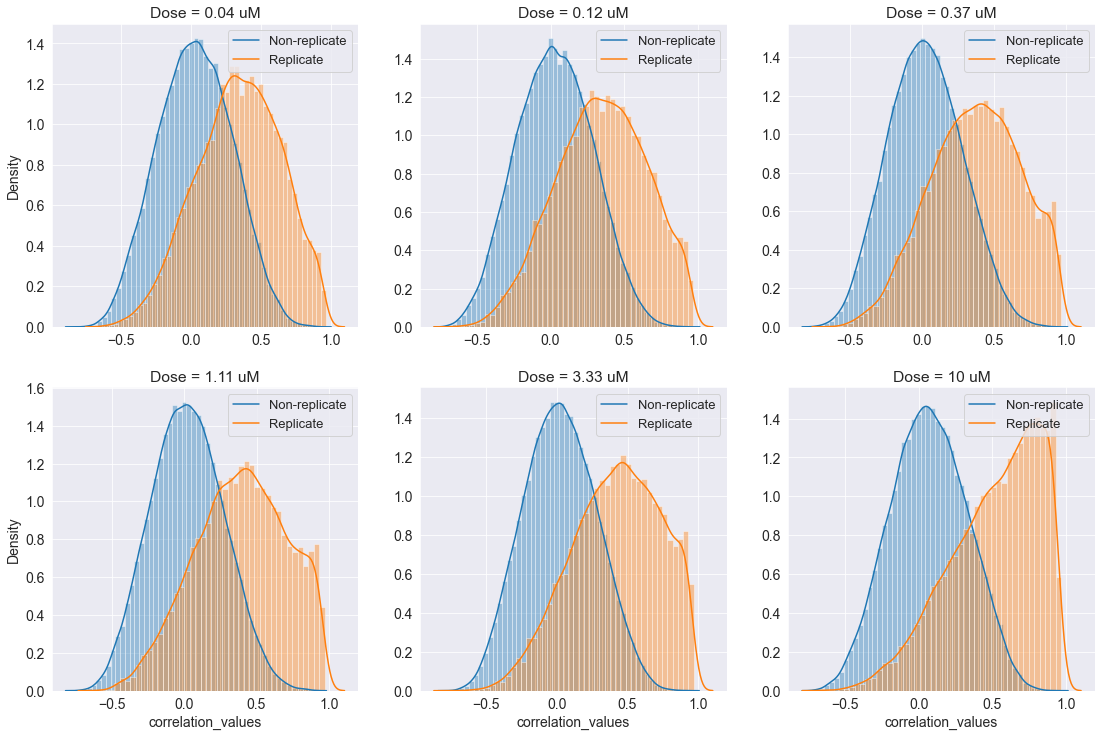

In [23]:
plot_replicate_vs_non_replicate(df_true_rep, df_rand_rep, 'cellpainting_figures', 'replicate_non_replicate_dist.png')

### - Compounds with statistically significant p-values i.e. their replicate median correlation values can be reproducible

In [24]:
def get_stat_sign_scores(df_med_scores, df_p_vals):
    
    """
    This function returns median scores and p-values of 
    compound that have statistically significant median replicate 
    correlation scores
    """
    df_cp_med = df_med_scores.set_index('cpd').rename_axis(None, axis=0).copy()
    df_p_vals = df_p_vals.set_index('cpd').rename_axis(None, axis=0).copy()
    df_p_values =df_p_vals.drop(['cpd_size'], axis = 1)
    
    stat_significant = [idx for idx in df_p_values.index if all(df_p_values.loc[idx] <= 0.05)]
    df_stat = df_p_vals.loc[stat_significant].reset_index().rename({'index':'cpd'}, axis = 1)
    df_stat_meds = df_cp_med.loc[stat_significant].reset_index().rename({'index':'cpd'}, axis = 1)
    
    return df_stat_meds, df_stat

In [25]:
df_stat_med_scores, df_stat_p_vals = get_stat_sign_scores(df_cpd_median_scores, df_null_p_vals)

In [26]:
df_sign_med_p_vals = merge_p_median_vals(df_stat_med_scores, df_stat_p_vals)

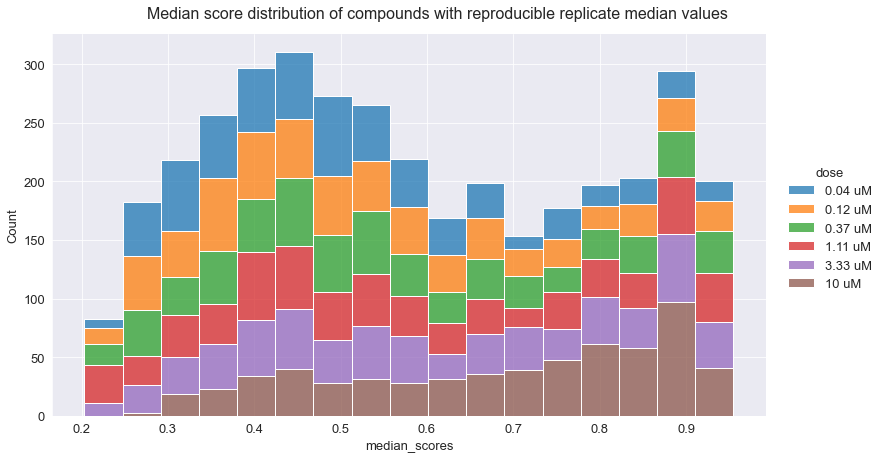

In [27]:
plot_median_score_distribution(df_sign_med_p_vals, 
                               "Median score distribution of compounds with reproducible replicate median values",
                               'cellpainting_figures', 'stat_sign_median_score_dist.png')

**Notice that the distribution of these statistically significant median scores (i.e. reproducible, p_values < 0.05) are positive values (between ~0.2 - 0.95)**

In [28]:
def save_to_pickle(values, path, file_name):
    """save values as pickle file"""
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    with open(os.path.join(path, file_name), 'wb') as handle:
        pickle.dump(values, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
save_to_pickle(df_sign_med_p_vals['cpd'].unique().tolist(), cp_level4_path, 'stat_significant_cpds.pickle')